# Main Jupyter Notebook for Reproducing the Experiment in "Prediction of Pedestrian Speed with Artificial Neural Networks" by Tordeux et al.

In [1]:
# Enable these if automatic reloading of modules is wanted

# Load extension for automatic reload of modules
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
import numpy as np

import preprocessing as prep
import plotting as plot

## Visualizing the Data

### Load one Bottleneck data file and one Corridor data file

In [3]:
# Bottleneck with diameter: 1.2m
b_120 = np.loadtxt("./Data/Bottleneck_Data/uo-180-120.txt")

# Corridor with 15 people:
c_015 = np.loadtxt("./Data/Corridor_Data/ug-180-015.txt")

### Convert the data to paths per pedestrian

In [4]:
b_120_paths = prep.get_ped_paths(b_120)
c_015_paths = prep.get_ped_paths(c_015)

#### Plot the paths of the pedestrians

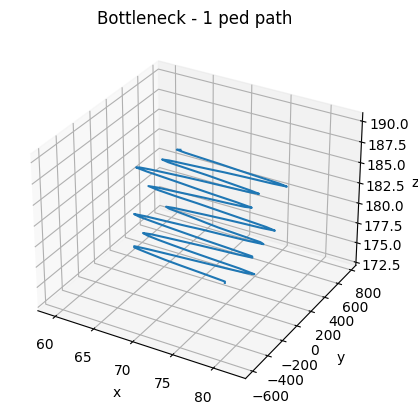

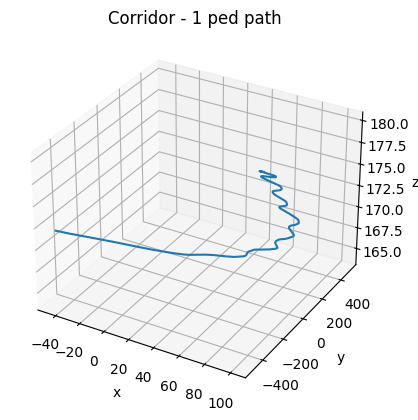

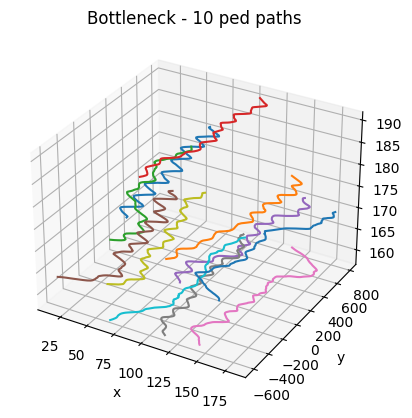

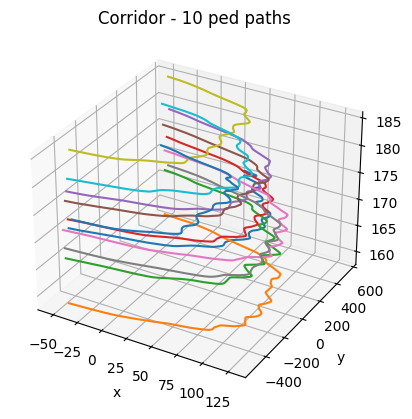

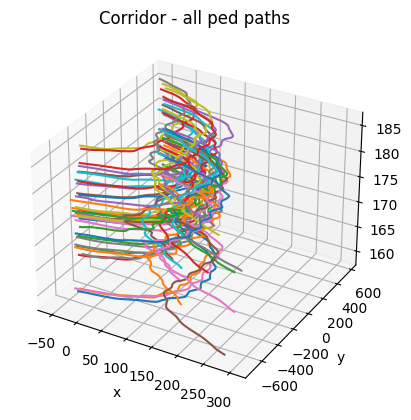

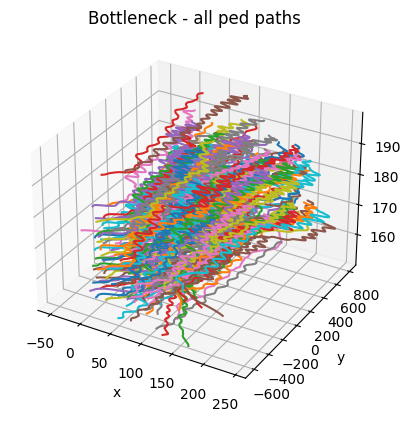

In [5]:
# Plot the path of the first pedestrians
plot.plot_ped_paths(b_120_paths[:1], title="Bottleneck - 1 ped path")
plot.plot_ped_paths(c_015_paths[:1], title="Corridor - 1 ped path")
# Note: [0] is not supported currently because a list is expected

# Plot the paths of the first 10 pedestrians
plot.plot_ped_paths(b_120_paths[:11], title="Bottleneck - 10 ped paths")
plot.plot_ped_paths(c_015_paths[:11], title="Corridor - 10 ped paths")

# Plot the paths of all pedestrians
plot.plot_ped_paths(c_015_paths, title="Corridor - all ped paths")
plot.plot_ped_paths(b_120_paths, title="Bottleneck - all ped paths")

### Calculate the speed of the pedestrian from the paths

In [6]:
b_120_speeds = prep.get_ped_speeds(b_120_paths)
c_015_speeds = prep.get_ped_speeds(c_015_paths)

#### Plot the speeds of the pedestrians

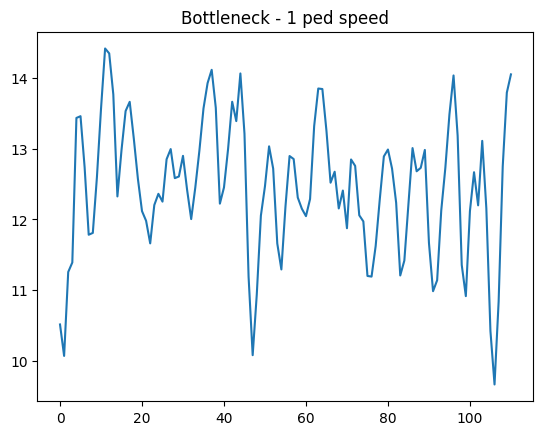

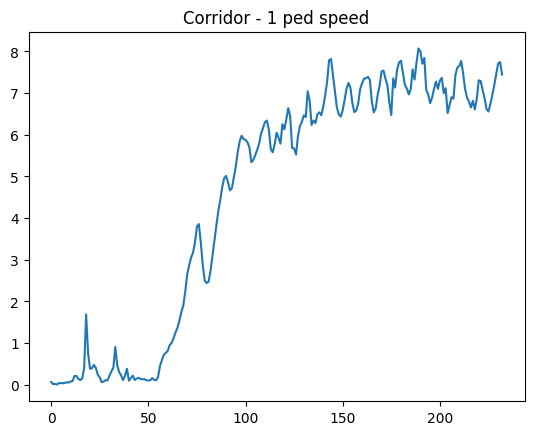

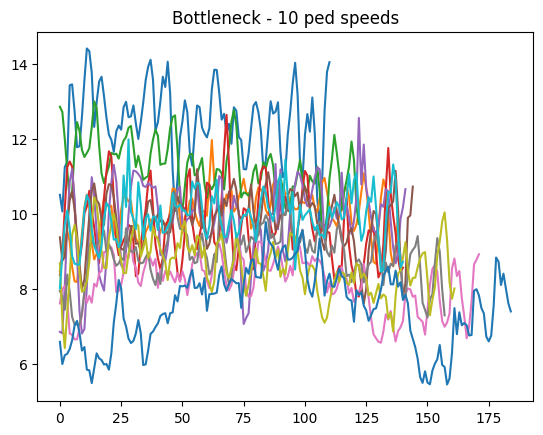

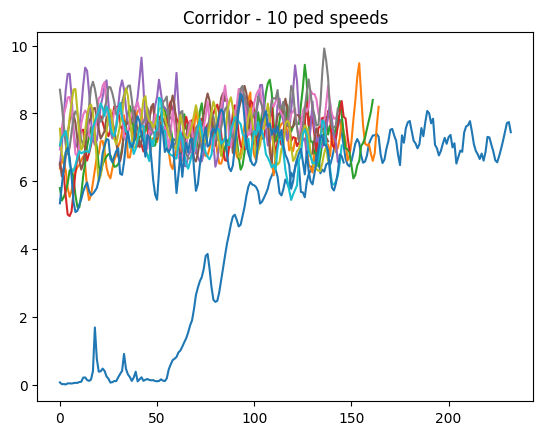

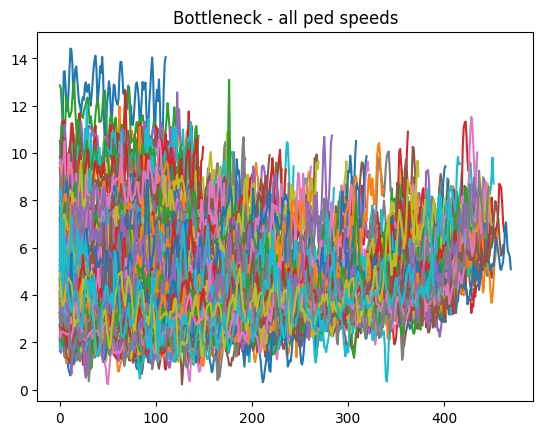

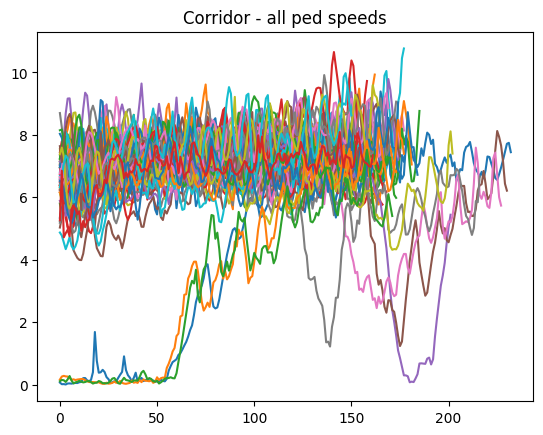

In [7]:
# Plot the speed of the first pedestrians
plot.plot_ped_speeds(b_120_speeds[:1], title="Bottleneck - 1 ped speed")
plot.plot_ped_speeds(c_015_speeds[:1], title="Corridor - 1 ped speed")
# Note: [0] is not supported currently because a list is expected

# Plot the speeds of the first 10 pedestrians
plot.plot_ped_speeds(b_120_speeds[:11], title="Bottleneck - 10 ped speeds")
plot.plot_ped_speeds(c_015_speeds[:11], title="Corridor - 10 ped speeds")

# Plot the speeds of all pedestrians
plot.plot_ped_speeds(b_120_speeds, title="Bottleneck - all ped speeds")
plot.plot_ped_speeds(c_015_speeds, title="Corridor - all ped speeds")

## Preprocessing

Converting the Pedestrian Data to the Input format is complete already.
Calculating the Speed Values of the Pedestrians separately is also done already (as can be seen above).
However, it is not integrated together yet, I (Simon) will do this either Thursday or next Week (or someone of you can do it)

### Showcase of Input Format:

In [8]:
c_230 = np.loadtxt("./Data/Corridor_Data/ug-180-230.txt")

In [9]:
# Builds a KDTree for each Frame to efficiently calculate the nearest neighbor
c_230_trees_dict = prep.get_kNN(c_230)

In [10]:
# Queries the KDTree for each Frame for each Pedestrian to get the 10 Nearest Neighbors for each Pedestrian for each Frame
c_230_datastructure_dict = prep.build_data_structure(c_230_trees_dict, k=10)

Tree: 3341.0	TreeIndex: 0	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 1	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 2	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 3	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 4	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 5	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 3341.0	TreeIndex: 6	NeighborIndex: 10
	k: 10	TreeItems: 10	ConsideredTreeItems: 9
	Not enough neighbors, adding np.inf to result array.
Tree: 

I am using `KDTree` from `scipy` to efficiently calculate the nearest neighbors.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

One Problem that still exists currently is to figure out what we want to do when we have less neighbors than we want (in the paper they use K=10)
We maybe want to just drop X,Y Pairs for the NN if they are "incomplete".
I currently just implemented adding np.inf values as the distance to non-existent neighbors, to be consistent with the KDTree.

TODO: Pairing of X,Y Pairs for the Neural Network

## Model Stuff - TODO

### What can be expected as Model Input once I am done with Preprocessing
- Model needs X,Y value pairs
- X: 2K+1 dimensions  (in the paper: K=10)
- Y: 1 dimension (just the speed)

$\Longrightarrow$ The model get's arrays with rows of length 2K+1 as input and the truth/Y value will be added in some way that makes it easy to use